# <center>TP : Arbres de décision</center>
<center>Prédiction des performances académiques d'un étudiant et interprétation</center>

*Objectifs* : 
    - Mettre en oeuvre les méthodes relatives aux arbres de décision introduites en cours afin de prédire le
    résultat à un examen final du cursus de licence. 
    - Interpréter ces résultats pour discuter de l'équité du système éducatif considéré.

Dans cette séance, les librairies suivantes seront utilisées : installez-les si nécessaire et chargez-les. Il sera utile de consulter l'aide de R pour comprendre à quoi correspondent les paramètres et les attributs d'une fonction donnée.

In [247]:
# install.packages("rpart.plot")
# install.packages("gbm")
library('rpart')
library("rpart.plot")
library('randomForest')
library('gbm')
library('nnet')
library('ggplot2')


## Table des matières

<p><div class="lev1"><a href="#Jeu-de-données-:-présentation-et-analyse"><span class="toc-item-num">1 - </span>Jeu de données : présentation et analyse</a></div>
<div class="lev1"><a href="#Arbre-de-décision"><span class="toc-item-num">2 - </span>Arbre de décision</a></div>
<div class="lev2"><a href="#Construction-de-l'arbre"><span class="toc-item-num">2.1 - </span>Construction de l'arbre</a></div>
<div class="lev2"><a href="#Elagage"><span class="toc-item-num">2.2 - </span>Elagage</a></div>
<div class="lev2"><a href="#Exploitation-des-résultats"><span class="toc-item-num">2.3 - </span>Exploitation des résultats</a></div>
<div class="lev1"><a href="#Amélioration-de-la-prédiction"><span class="toc-item-num">3 - </span>Amélioration de la prédiction</a></div>
<div class="lev2"><a href="#Bagging-(Bootstrap-AGGregatING)"><span class="toc-item-num">3.1 - </span>Bagging (Bootstrap AGGregatING)</a></div>
<div class="lev2"><a href="#Forêts-aléatoires"><span class="toc-item-num">3.2 - </span>Forêts aléatoires</a></div>
<div class="lev2"><a href="#Boosting"><span class="toc-item-num">3.3 - </span>Boosting</a></div>
<div class="lev1"><a href="#Comparaison"><span class="toc-item-num">4 - </span>Comparison</a></div>
<div class="lev2"><a href="#Interprétation"><span class="toc-item-num">5 - </span>Interprétation</a></div>
<div class="lev2"><a href="#Références"><span class="toc-item-num"> </span>Références</a></div>

## Jeu de données : présentation et analyse

Cette séance est inspirée des articles <a name="ref-1"/>[(Hussain et al., 2018)](#hussain) et <a name="mcdaniel"/>[(McDaniel, 2018)](#cite-calicoww2:2) et le jeu de données original est disponible sur [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Student+Academics+Performance). Le jeu de données étudié durant cette séance contient $300$ observations de $21$ prédicteurs présentés dans le tableau ci-dessous. Il s'agit de données concernant des étudiants indiens en fin de troisième année de licence (pour faciliter l'interprétation, nous transposons le système d'éducation indien en un équivalent français, avec les inexactitudes que cela peut induire).

|Nom  |Description|Valeurs|
|-----|-----------|-------|
|GE   |Gender  | Male (M)/ Female (F)|
|CST  |Caste  | General/SC/ST/OBC/MOBC|
|TNP  |Class X Percentage | $[0,1]$ |
|TWP  |Class XII Percentage |$[0,1]$ |
|IAP  |Internal Assess Percentage |$[0,1]$ |
|ARR  |Previous failed test |Yes (Y)/No (N) |
|MS   |Marital Status            | Married / Unmarried |
|LS   |Live in Town or Village              |Town (T)/Village (V)|
|AS   |Admission Category |Free/Paid|
|FMI  |Family Monthly Income (in Rupee)|$[0,+\infty[$|
|FS   |Family Size                     |$\mathbb{N}$|
|FQ   |Father Qualification              |Illiterate (Il)/Under Class X (UM)/10/12/Degree/PG|
|MQ   |Mother Qualification               |Illiterate (Il)/Under Class X (UM)/10/12/Degree/PG|
|FO   |Father Occupation               |Service/Business/Retired/Farmer/Other|
|MO   |Mother Occupation               |Service/Business/Retired/Housewife/Other|
|NF   |Number of Friends | $\mathbb{N}$|
|SH   |Study Hours |$[0,6]$ (h)|
|SS   |Student School Attended at Class X level | Govt./Private|
|ME   |Medium|English(Eng.)/Assamese(Asm.)/Hindi(Hin.)/Bengali(Ben.)|
|TT   |Home to College Travel Time|$[0,2]$ (h)|
|ATD  |Class Attendance Percentage|$[0,1]$|

Détails :
- `CST` : 'General' désigne les castes qui ne sont pas discriminées. Les $4$ autres désignations (SC:Schelule Caste; ST:Schedule Tribe; OBC:Other Backward Class; MOBC:Minorities and Other Backward Class) recouvrent des classes sociales souvent victimes de discrimination. Par exemple, 'SC' inclut les Dalits, aussi appelés intouchables.
- `TNP` et `TWP` : le 'class X exam' est un certificat général de fin d’études secondaires dans le système scolaire indien; pour simplifier, on pourra considérer qu'il est équivalent au brevet des collèges en France. Le 'class XII exam' est un certificat général de fin d’études secondaires supérieures, on pourra considérer qu'il est équivalent au baccalauréat en France. La valeur associée, renormalisée, désigne le pourcentage de bonnes réponse à ces examens. Voir [ici](https://en.wikipedia.org/wiki/Higher_Secondary_School_Certificate) pour plus de détails. 
- `IAP` : on pourra considérer cette variable comme la note de contrôle continu obtenue durant la licence.
- `ARR` : 'Yes' signifie que l'étudiant doit passer des rattrapages.
- `FQ` : '10' (resp. 12) désigne la validation de l'examen de class X (resp. XII); 'Degree' un niveau licence ou équivalent et 'PG'un niveau master ou plus.
- `ME` : le médium est la langue utilisée pour l'instruction et les examens.

La variable à prédire, ou réponse, notée `ESP` est le 'End Semester Percentage' qui est le résultat obtenu à l'examen final pour l'obtention du diplôme de licence. `ESP` prend $2$ valeurs : 
- 'Pass' lorsque l'étudiant obtient un score de plus de 50%
- 'Fail' lorsque l'étudiant obtient un score de moins de 50%

Les données sont directement séparées en Train.csv pour l'apprentissage et Test.csv pour la validation.

><u>Tâche 1</u> : Importer et visualiser les données : y a-t-il des données manquantes ? aberrantes ? inutiles ? Quelle est la taille de l'ensemble d'apprentissage ? de l'ensemble de test ? Est-ce que cela est cohérent ?
>Quelles sont les données :
>- quantitatives ? 
>- qualitatives ordonnées ? 
>- qualitatives non-ordonnées ? 
>
>La tâche de prédiction relève-t-elle de la régression ou de la classification ?

In [248]:
#insert code
Train=read.csv('Train.csv') 
Test=read.csv('Test.csv') 
#------------
sum(is.na(Train))
sum(is.na(Test))
#------------
summary(Train)
summary(Test)


[1] 0

[1] 0

 GE        CST          TNP              TWP            IAP         ARR    
 F:114   G   :55   Min.   :0.3000   Min.   :0.31   Min.   :0.3100   N:110  
 M:111   MOBC:40   1st Qu.:0.4400   1st Qu.:0.47   1st Qu.:0.5100   Y:115  
         OBC :91   Median :0.5200   Median :0.54   Median :0.5700          
         SC  :11   Mean   :0.5271   Mean   :0.55   Mean   :0.5894          
         ST  :28   3rd Qu.:0.5900   3rd Qu.:0.61   3rd Qu.:0.6700          
                   Max.   :0.9600   Max.   :0.95   Max.   :1.0000          
         MS      LS         AS           FMI              FS        
 Married  :  1   T: 48   Free:142   Min.   : 2552   Min.   : 1.000  
 Unmarried:224   V:177   Paid: 83   1st Qu.: 4517   1st Qu.: 2.000  
                                    Median : 7481   Median : 4.000  
                                    Mean   :10360   Mean   : 5.004  
                                    3rd Qu.:12097   3rd Qu.: 7.000  
                                    Max.   :70593   Ma

 GE       CST          TNP              TWP              IAP         ARR   
 F:36   G   :21   Min.   :0.3000   Min.   :0.3000   Min.   :0.3000   N:38  
 M:39   MOBC:14   1st Qu.:0.4400   1st Qu.:0.4950   1st Qu.:0.4950   Y:37  
        OBC :27   Median :0.5200   Median :0.5500   Median :0.5500         
        SC  : 2   Mean   :0.5345   Mean   :0.5631   Mean   :0.5827         
        ST  :11   3rd Qu.:0.5950   3rd Qu.:0.6250   3rd Qu.:0.6650         
                  Max.   :1.0000   Max.   :0.9200   Max.   :0.9600         
         MS     LS        AS          FMI              FS              FQ    
 Unmarried:75   T:12   Free:49   Min.   : 2780   Min.   : 1.000   10    : 8  
                V:63   Paid:26   1st Qu.: 5046   1st Qu.: 3.000   12    :10  
                                 Median : 8330   Median : 4.000   Degree: 9  
                                 Mean   :11651   Mean   : 4.667   Il    :12  
                                 3rd Qu.:11510   3rd Qu.: 6.000   Pg    : 3  


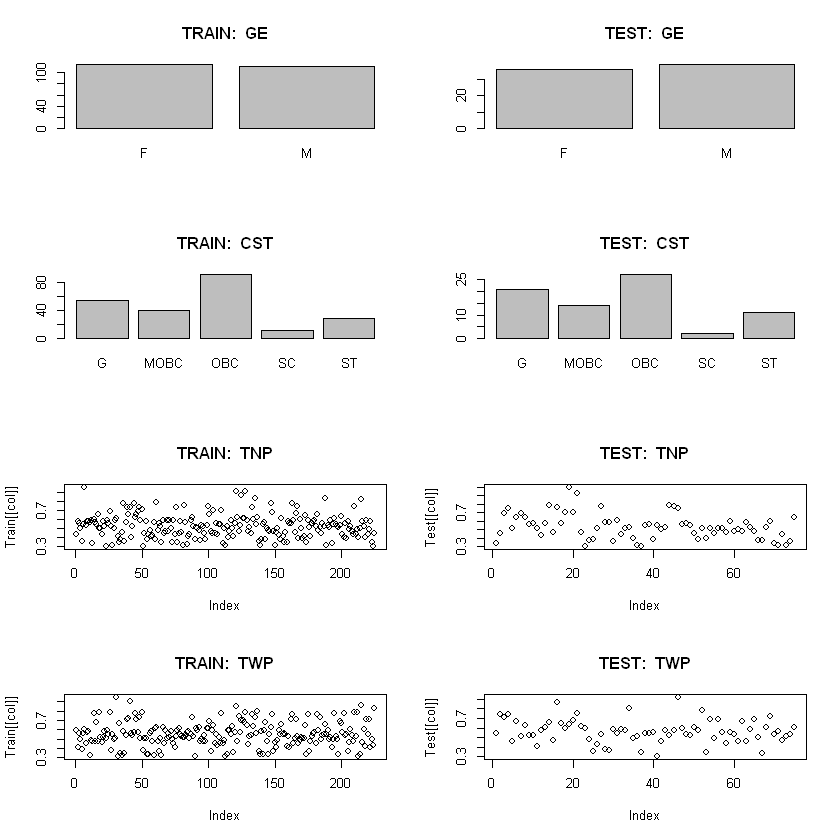

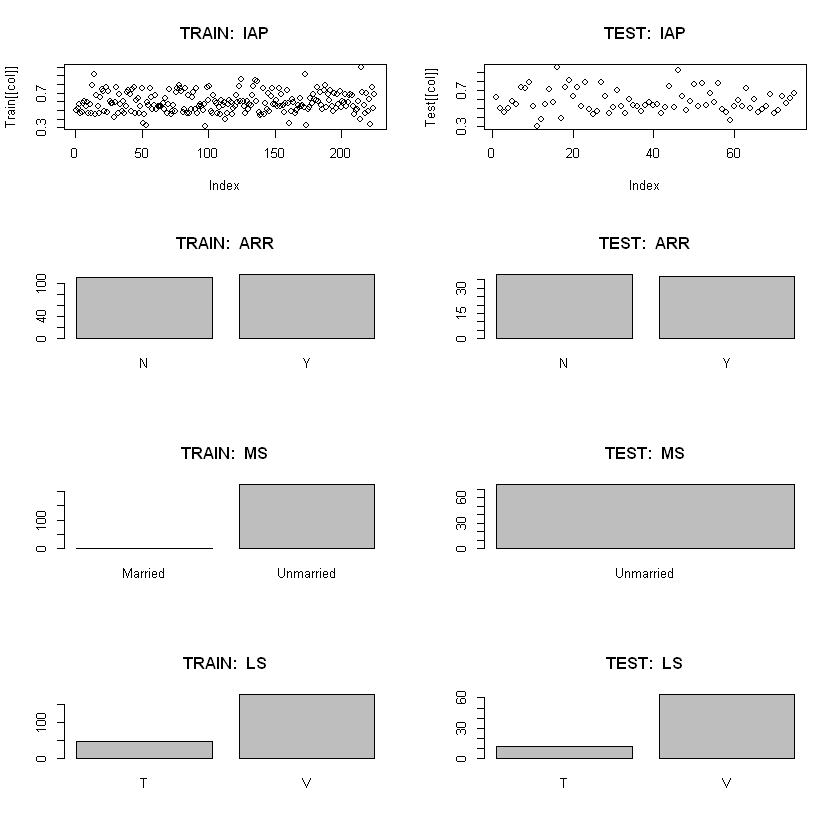

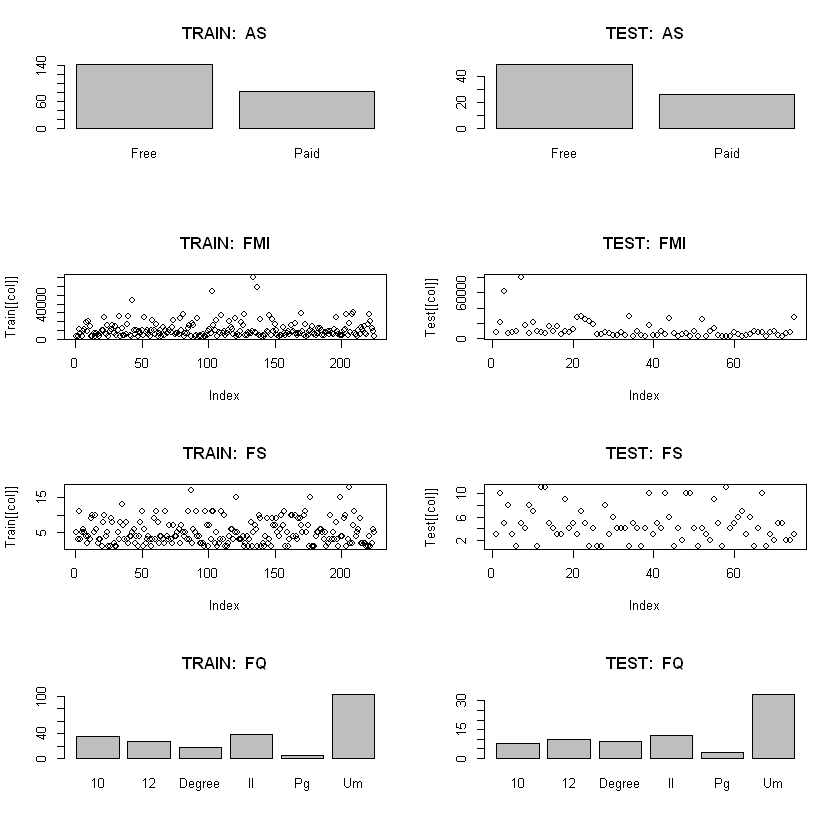

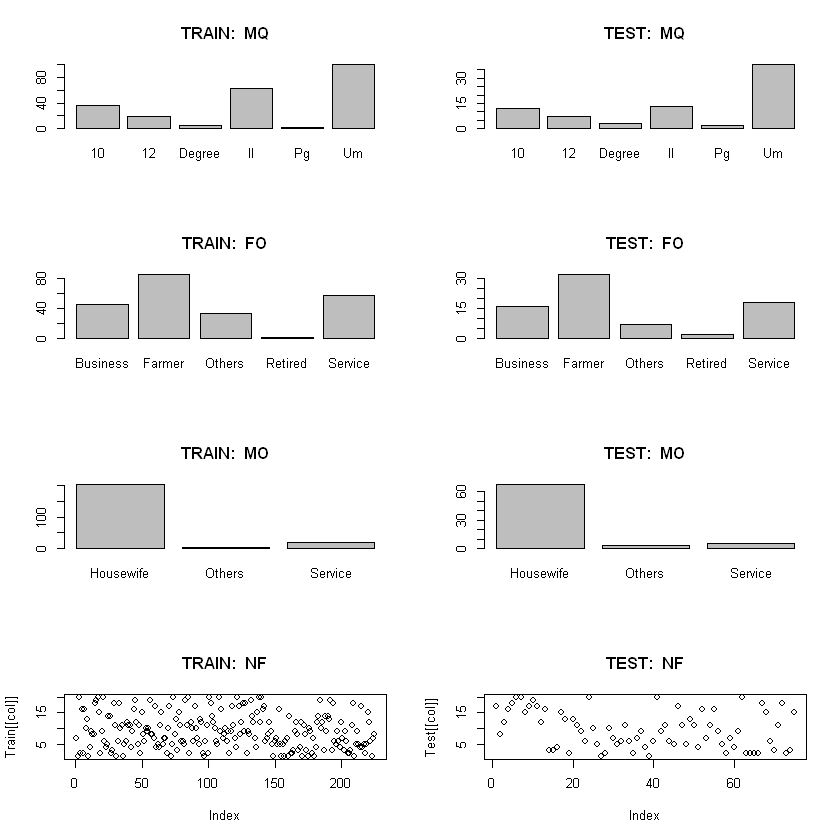

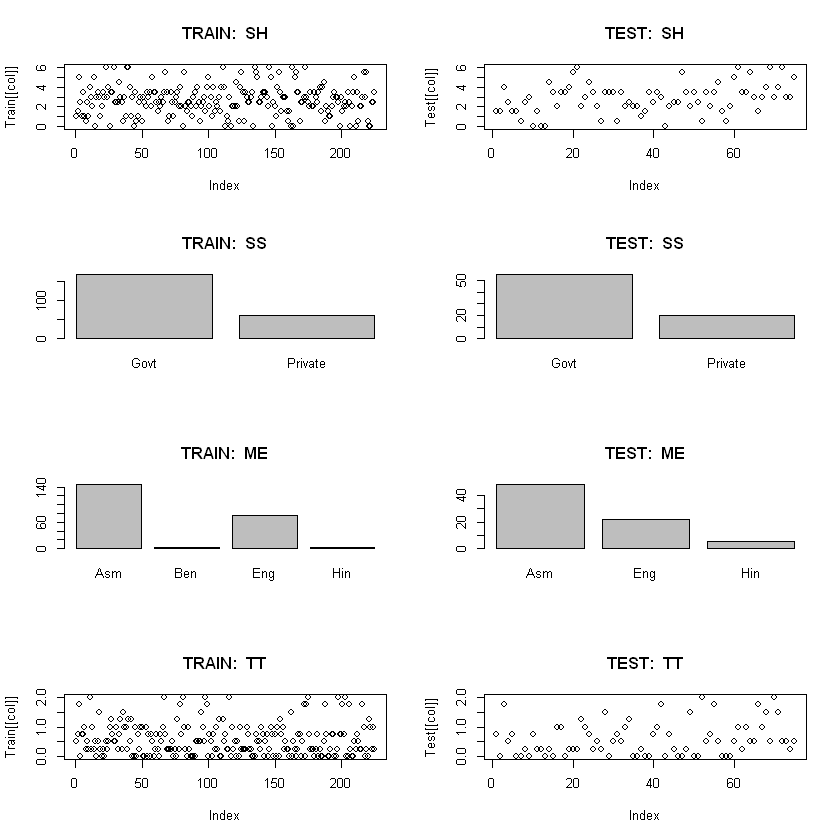

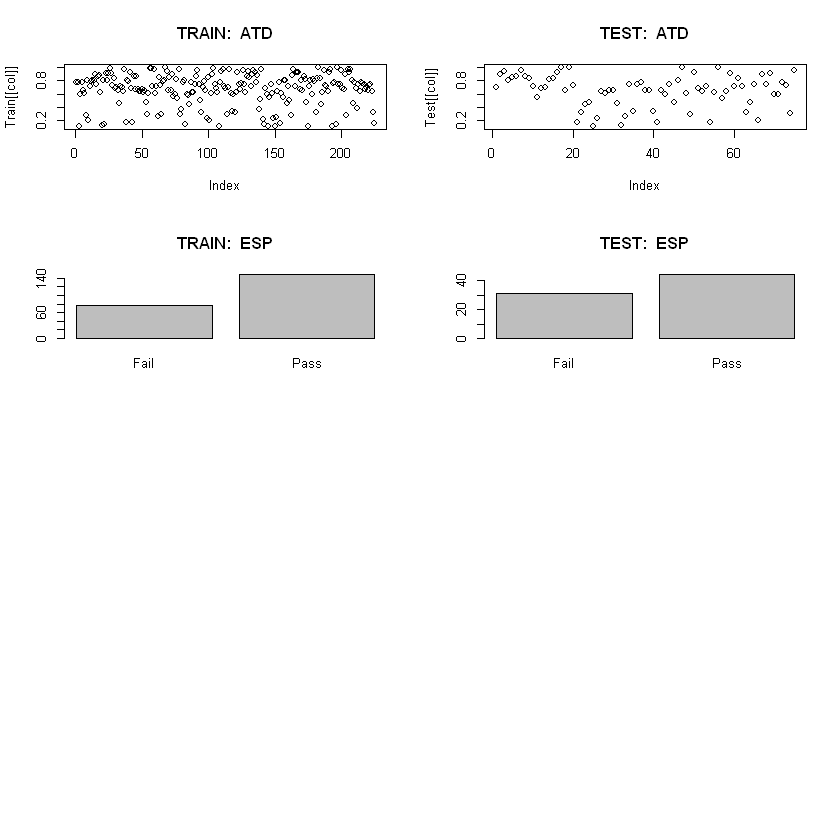

In [249]:
par(mfrow = c(length(c('MO', 'FO', 'MQ', 'FQ')), 2))
for (col in colnames(Train)){
        plot(Train[[col]], main=paste('TRAIN: ', col))
        plot(Test[[col]], main=paste('TEST: ', col))
}

In [250]:
print("Length and percentage for the Train dataset")
length(Train$GE)
paste(length(Train$GE)* 100 / 300, "%")
print("Length and percentage for the Test dataset")
length(Test$GE)
paste(length(Test$GE) * 100 / 300, "%")

[1] "Length and percentage for the Train dataset"


[1] 225

[1] "75 %"

[1] "Length and percentage for the Test dataset"


[1] 75

[1] "25 %"

><u>Réponse</u> : 
<li>Pas de données manquantes, ni aberrantes
<li>La variables MS ne nous sert à rien, dans le jeu de données de Train il n'y a qu'une seul occurence de <b>married</b> alors qu'il y a 224 occurrences de <b>unmarried</b> (il n'y a que des <b>unmarried</b> dans le jeu de données du Test), ce qui fait que cette variable n'est pas importante pour notre entrainement
<li>Les variables ('MO', 'FO', 'MQ', 'FQ') ne sont pas bien distribuées, et représente des données non équilibrées pour entraîner le modèle
<li>Le jeu de Train contient 225 lignes, alors que le jeu de Test contient 75 lignes
<li>Les variables quantitatives : (`TNP`, `TWP`, `IAP`,`FMI`,`FS`,`NF`, `SH`, `TT`, `ATD`)
<li>Les variables qualitatives : (`GE`, `CST`, `ARR`,`MS`, `LS`, `AS`,`FO`,`MO`, `SS`, `ME`)
<li>C'est une tâche basée sur la classification

## Arbre de décision


### Construction de l'arbre

><u>Tâche 2</u> : Sur l'ensemble d'apprentissage, déterminer l’arbre de décision permettant de prédire la catégorie à partir des variables explicatives en utilisant la fonction `rpart` avec les paramètres par défault (voir [ici](https://stat.ethz.ch/R-manual/R-patched/library/rpart/html/rpart.html)) :
- quel critère est minimisé lors d'une coupe ? 
- combien y a-t-il au minimum d'observations dans chaque feuille ?
- à quoi correspond le paramètre `cp` dans `rpart.control`?
>
>Afficher l'arbre à l'aide de la fonction `rpart.plot`. On considère le nœud terminal (la feuille) $n^o 3$ :
- Quelle est la prédiction effectuée ?
- Avec quelle probabilité ?
- Sur combien d’observations ?

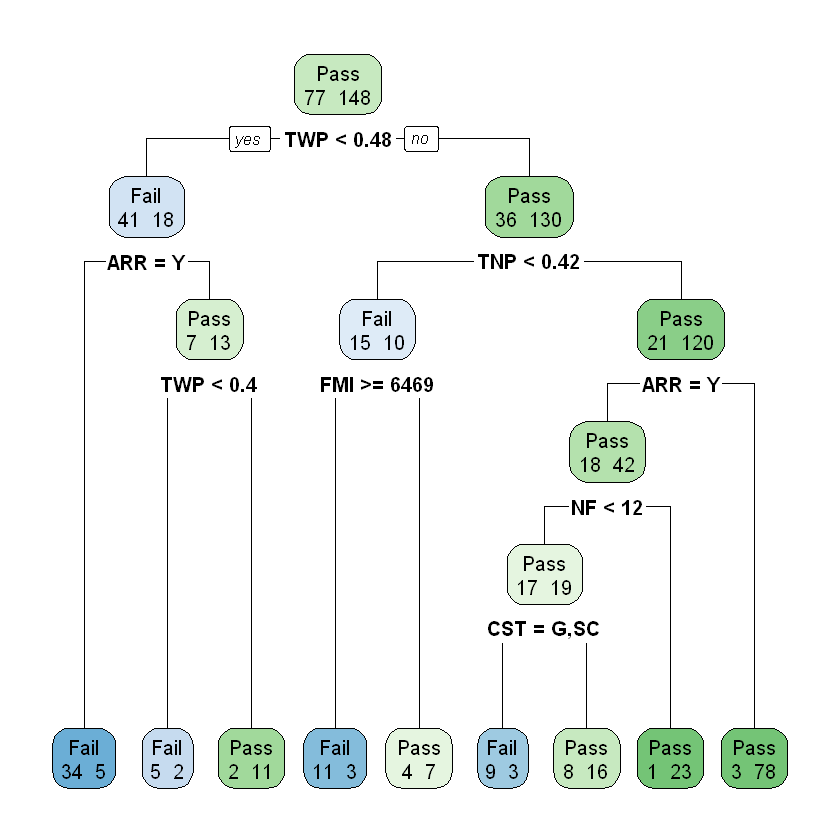

In [251]:
X_train=Train[,-22]
y_train=Train[,22]
X_test=Test[,-22]
y_test=Test[,22]

fit <- rpart(y_train~ .,data=X_train)
rpart.plot(fit,extra=1)

In [252]:
rpart.control()

$minsplit
[1] 20

$minbucket
[1] 7

$cp
[1] 0.01

$maxcompete
[1] 4

$maxsurrogate
[1] 5

$usesurrogate
[1] 2

$surrogatestyle
[1] 0

$maxdepth
[1] 30

$xval
[1] 10

><u>Réponse</u> : 
<li>Le critère à réduire est la variance
<li>Au moins 20/3
<li>Cp représente "Complexity Parameter" qui traite le sujet des splits. Plus CP est petit, plus est l'arbre est grand, et plus le CP est grand, plus l'arbre est petit
<br>
<li>La prédiction est Pass avec une probabilité de 84.61%. Une observation de 13 occurrences sur la base de 225 observations

En classification, on rappelle que la qualité du modèle est mesurée via la précision :
$$precision(y,\hat{y})=\frac{1}{n}\sum_{i=1}^n 1_{y_i=\hat{y}_i}$$
où $n$ est la taille de l'ensemble de test, $\hat{y}_{i}$ la valeur prédite du $i^{ème}$ individu et $y_i$ sa vraie valeur. Le taux d'erreur est donné par $1-precision(y,\hat{y})$.

><u>Tâche 3</u> : Evaluer la qualité du modèle sur les ensembles d'entraînement et de test. Afficher la matrice de confusion et le taux d'erreur de classification pour chacun des ensembles.

In [253]:
#insert code
# For the train
confMat<-table(predict(fit, X_train, type = "class"), y_train)
precision<-sum(diag(confMat))/sum(confMat)
print(confMat)
print(1-precision)

# For the test
confMat<-table(predict(fit, X_test, type = "class"), y_test)
precision<-sum(diag(confMat))/sum(confMat)
print(confMat)
print(1-precision)

      y_train
       Fail Pass
  Fail   59   13
  Pass   18  135
[1] 0.1377778
      y_test
       Fail Pass
  Fail   14    6
  Pass   17   38
[1] 0.3066667


><u>Tâche 4</u> (optionelle): Sur l'ensemble d'apprentissage, pour les deux critères (indice de Gini et entropie), construire un arbre maximal avec (idéalement) une observation par feuille, un arbre avec au plus $m=10$ observations par feuilles et au plus $m=20$ observations par feuilles. Calculer le taux d'erreur pour chaque cas. Empiriquement, pour ce jeu de données, quel critère de coupe est préférable ?

In [254]:
#insert code
precision_gini<-c()
for (i in c(11,21)){
    fit <- rpart(y_train~ .,data=X_train,control = rpart.control(cp=0,minsplit=i))
    confMat<-table(predict(fit, X_test, type = "class"), y_test)
    precision<-sum(diag(confMat))/sum(confMat)
    precision_gini<-c(precision_gini,1-precision)
}

precision_entropie<-c()
for (i in c(11,21)){
    fit <- rpart(y_train~ .,data=X_train,parms=list(split = "information"),control = rpart.control(cp=0,minsplit=i))
    confMat<-table(predict(fit, X_test, type = "class"), y_test)
    precision<-sum(diag(confMat))/sum(confMat)
    precision_entropie<-c(precision_entropie,1-precision)
}

#arbre max entropie
fit <- rpart(y_train~ .,data=X_train,parms=list(split = "information"),control = rpart.control(cp=-1,minsplit=2,minbucket=1))
confMat<-table(predict(fit, X_test, type = "class"), y_test)
precision_max_e<-1-sum(diag(confMat))/sum(confMat)

#arbre max gini
fit <- rpart(y_train~ .,data=X_train,control = rpart.control(cp=-1,minsplit=2,minbucket=1))
confMat<-table(predict(fit, X_test, type = "class"), y_test)
precision_max_g<-1-sum(diag(confMat))/sum(confMat)

#arbre par défaut, entropie
fit <- rpart(y_train~ .,data=X_train,parms=list(split = "information"))
confMat<-table(predict(fit, X_test, type = "class"), y_test)
precision_defaut_e<-1-sum(diag(confMat))/sum(confMat)

print(paste('Gini precision: ', precision_gini))
print(precision_max_g)
print(paste('Entropie: ', precision_entropie))
print(precision_max_e)
print(precision_defaut_e)

[1] "Gini precision:  0.253333333333333" "Gini precision:  0.32"             
[1] 0.24
[1] "Entropie:  0.28"              "Entropie:  0.266666666666667"
[1] 0.2533333
[1] 0.2666667


><u>Réponse</u> : La précision avec l'indice de Gini est meilleure que celle de l'Entropie

### Elagage

La qualité de prédiction de l'arbre varie avec le nombre d'observations par feuille.

Nous allons dans cette partie chercher de manière plus systématique le meilleur sous-arbre en terme de prédiction. 

Pour ce faire, nous appliquons la méthode vue en cours, qui consiste, à partir de l'arbre maximal  (voir aussi [ici](http://mlwiki.org/index.php/Cost-Complexity_Pruning)):
<ol>
<li> Sélectionner une suite de sous-arbres emboîtés et la pénalité $\alpha$ correspondante via la méthode de <i>cost complexity pruning</i>.</li>
<li> Sélectionner le 'meilleur' sous-arbre en effectuant une validation croisée sur les pénalités $\alpha$.</li>
</ol>

><u>Tâche 5</u> : la méthode `rpart` de R effectue déjà directement les deux points ci-dessus. Les valeurs sont stockées dans l'attribut `cptable` de l'objet arbre fourni. Pour visualiser ces $\alpha$ et l'erreur correspondante en validation croisée, utiliser la fonction `plotcp`. Donner la valeur $\alpha$ correspondant au meilleur sous-arbre.

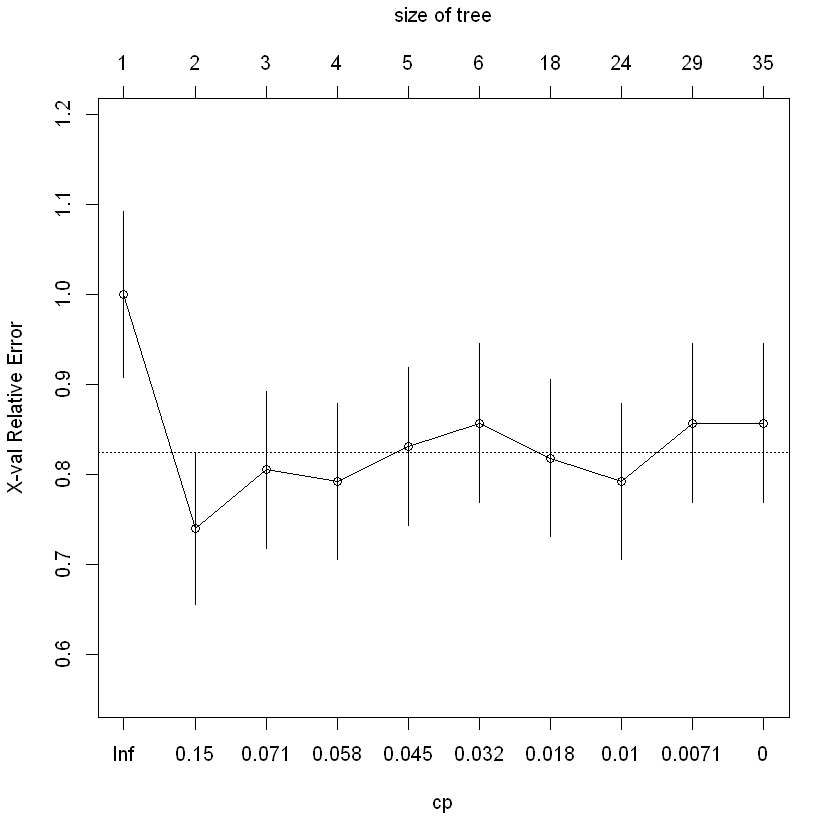

In [255]:
fit.max <- rpart(y_train~ .,data=X_train,control = rpart.control(cp=0, minsplit = 2,minbucket =1))
plotcp(fit.max)

In [256]:
fit.max$cptable

CP,nsplit,rel error,xerror,xstd
0.298701299,0,1.00000000,1.0000000,0.09242602
0.077922078,1,0.70129870,0.7402597,0.08472471
0.064935065,2,0.62337662,0.8051948,0.08703775
0.051948052,3,0.55844156,0.7922078,0.08659740
0.038961039,4,0.50649351,0.8311688,0.08788625
0.025974026,5,0.46753247,0.8571429,0.08869284
0.012987013,17,0.15584416,0.8181818,0.08746732
0.007792208,23,0.07792208,0.7922078,0.08659740
0.006493506,28,0.03896104,0.8571429,0.08869284
0.000000000,34,0.00000000,0.8571429,0.08869284


><u>Réponse</u> : On prend $\alpha=0.0259$

###  Exploitation des résultats

><u>Tâche 6</u> : L'élagage a permi de sélectionner le meilleur sous-arbre. Construire cet arbre à l'aide de la fonction `prune`. Quel est le taux d'erreur de classification de cet arbre sur l'ensemble de test ? Afficher la matrice de confusion. Quel est le nombre de mal classés par l’arbre dans l’échantillon ? Visualiser cet arbre. Quelles sont les trois variables les plus importantes pour la détermination de la catégorie ?
>
> On considère une nouvelle observation (F,OBS,0.38,0.45,0.49,Y,Unmarried,V,Paid,5720,1,10,Um,Others,Housewife,20,	3,Govt,Asm,1,0.78) : prédire le résultat de cet étudiant à l'examen.

[1] 0.2533333
      y_test
       Fail Pass
  Fail   18    6
  Pass   13   38


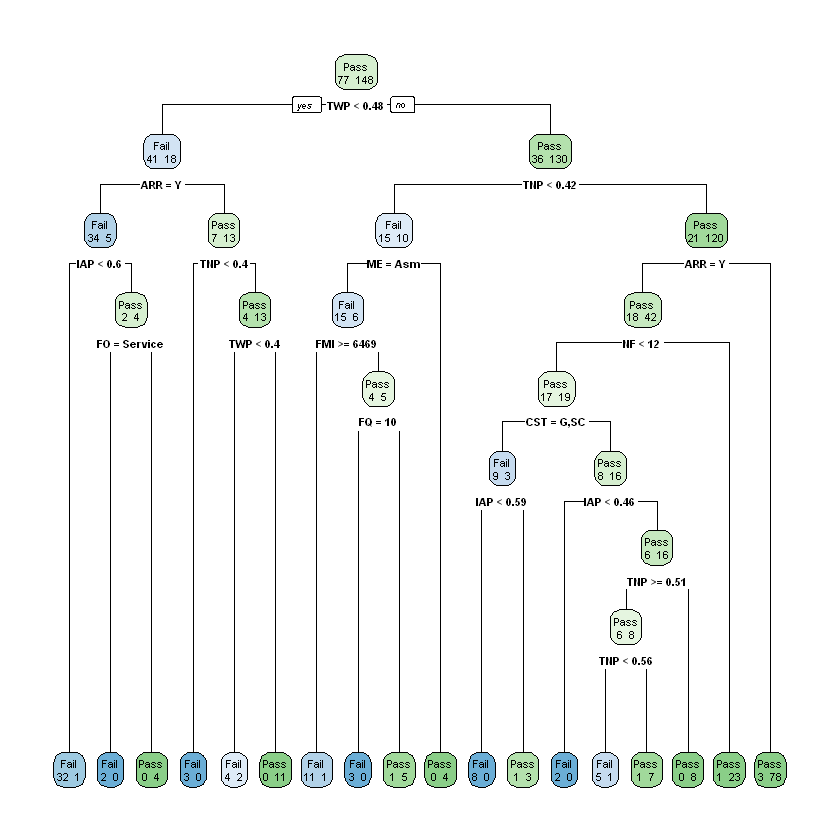

In [257]:
tree<-prune(fit.max,cp=0.0259)
#insert code
rpart.plot(tree, extra=1)

confMat<-table(predict(tree, X_test, type = "class"), y_test)
precision<-sum(diag(confMat))/sum(confMat)
print(1-precision)
print(confMat)


In [258]:
predict(c('F','OBS',0.38,0.45,0.49,'Y','Unmarried','V','Paid',5720,1,10,'Um','Others','Housewife',20,	3,'Govt','Asm',1,0.78), tree)

ERROR: Error in UseMethod("predict"): no applicable method for 'predict' applied to an object of class "character"


><u>Réponse</u> : Le taux d'erreurs est : $0.2533333$%. Les non classés sont : 19 et les variables importantes sont : ('TWP', 'ARR', 'TNP').<br>
<u>Nouvelle observation</u> (F,OBS,0.38,0.45,0.49,Y,Unmarried,V,Paid,5720,1,10,Um,Others,Housewife,20,	3,Govt,Asm,1,0.78) : <b>dazdz

><u>Tâche 7</u> (facultatif) : Observer comment les résultats précédents sont impactés (en particulier dans les tâches 6 et 7) si l'on change les échantillons d'entraînement et de test. Comment expliquer ces résultats ?

[1] 0.2666667
      y_test2
       Fail Pass
  Fail   15   16
  Pass    4   40


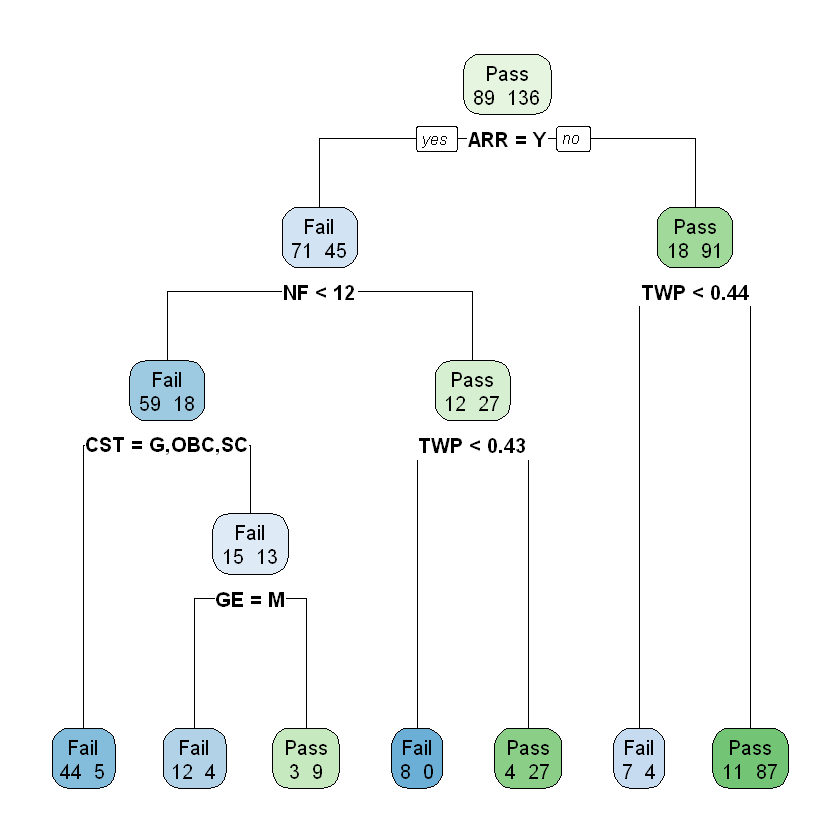

In [ ]:
#insert code

Train2<-Train
Train2[(151:225),]<-Test
Test2<-Train[(151:225),]

X_train2=Train2[,-22]
y_train2=Train2[,22]
X_test2=Test2[,-22]
y_test2=Test2[,22]

fit <- rpart(y_train2~ .,data=X_train2)
rpart.plot(fit,extra=1)

confMat<-table(predict(fit, X_test2, type = "class"), y_test2)
precision<-sum(diag(confMat))/sum(confMat)
print(1-precision)
print(confMat)

><u>Réponse</u> : A cause de la nature de variance des arbres de décision, le moindre changement d'échantillon entraine un changement complètement différent au niveau des résultats obtenus

## Amélioration de la prédiction

Nous allons maintenant mettre en place les méthodes de réduction de la variance introduites en cours afin d'améliorer la prédiction.

### Bagging (<b>B</b>ootstrap <b>AGG</b>regat<b>ING</b>)


><u>Tâche 8</u> : Rappeler quelle est la différence entre Bagging et Forêt aléatoire. Effectuer une prédiction en utilisant la méthode de Bagging (fonction `randomForest` se trouvant dans la librairie du même nom). Tracer le taux d'erreur sur l'ensemble de test en fonction du nombre d'arbres utilisés. Tracer sur le même graphe le taux d'erreur 'out-of-bag'.

 [1] 0.2400000 0.2000000 0.2133333 0.1866667 0.2000000 0.2000000 0.2266667
 [8] 0.2133333 0.2266667 0.2133333 0.2000000 0.2133333


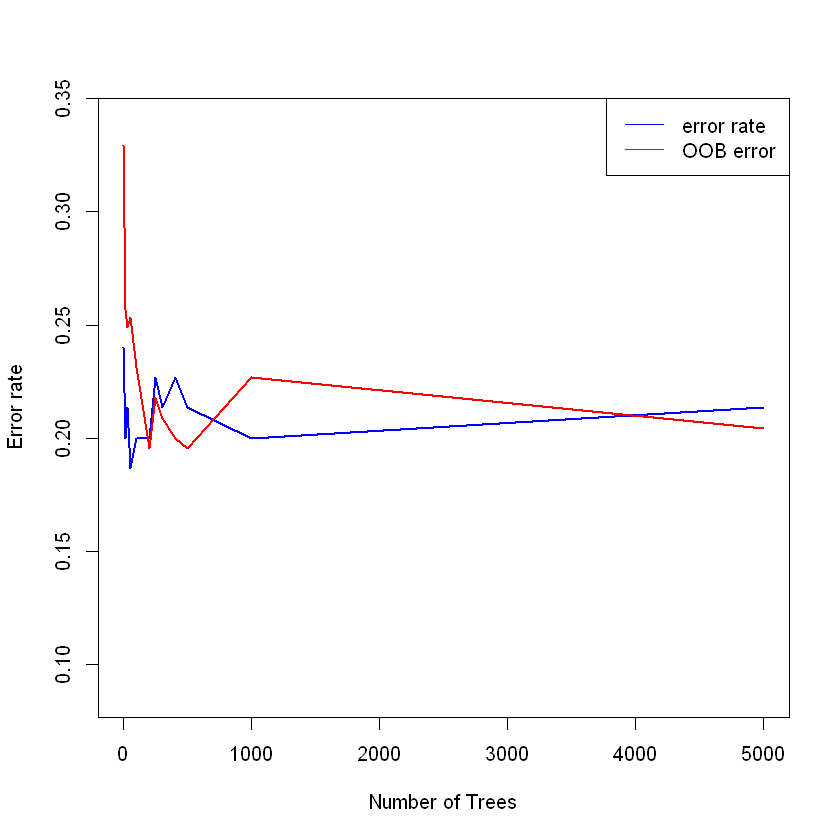

In [ ]:
error_rate<-c()
error_rate_oo<-c()
p=21
Ntrees=c(1,10,30,50,100,200,250,300,400,500,1000,5000)
for(i in Ntrees){
    fit.rf <- randomForest(y_train ~ ., data=X_train,xtest=X_test,ytest=y_test,ntree=i ,mtry=p, importance=TRUE)
    cm<-fit.rf$confusion
    error_rate_oo<-c(error_rate_oo,1-sum(diag(cm))/sum(cm[,-3]))
    confMat<-fit.rf$test$confusion
    error_rate<-c(error_rate,1-sum(diag(confMat))/sum(confMat[,-3]))
}
print(error_rate)
plot(Ntrees,error_rate,type='l',col='blue',lwd=2,ylim=c(min(error_rate)-0.1,max(error_rate)+0.1),ylab="Error rate",xlab="Number of Trees")
points(Ntrees,error_rate_oo,type='l',col='red',lwd=2)
legend("topright", legend=c("error rate","OOB error"),lty = c(1,1),col=c("blue","red"))

><u>Réponse</u> : La différence entre Bootstrap Aggregating et Forêt aléatoire est que la méthode du Bagging utilise n'importe quel modèle, alors que la forêt aléatoire utilise un ensemble d'arbres de décision, ainsi que l'arbre de décision prend un échantillon non seulement des lignes, mais aussi des variables.

><u>Tâche 9</u> : Déterminer quelles sont les variables les plus importantes en utilisant l'attribut `importance` et/ou la fonction `varImpPlot`.

,Fail,Pass,MeanDecreaseAccuracy,MeanDecreaseGini
GE,-4.052761e-04,-2.482226e-04,-3.075893e-04,0.1926151
CST,-1.666370e-03,1.503693e-03,3.973493e-04,3.7350938
TNP,5.466624e-02,2.948307e-02,3.764480e-02,14.9613518
TWP,6.690099e-02,3.349790e-02,4.458826e-02,20.5460887
IAP,5.969873e-02,9.440962e-03,2.631962e-02,12.6592447
ARR,6.480495e-02,3.157369e-02,4.254944e-02,12.7132305
MS,0.000000e+00,0.000000e+00,0.000000e+00,0.2414615
LS,-1.340989e-04,-7.083144e-05,-8.379621e-05,0.1645945
AS,2.117907e-03,1.650159e-03,1.817413e-03,0.7772331
FMI,1.537038e-04,4.128239e-03,2.844432e-03,5.5410879


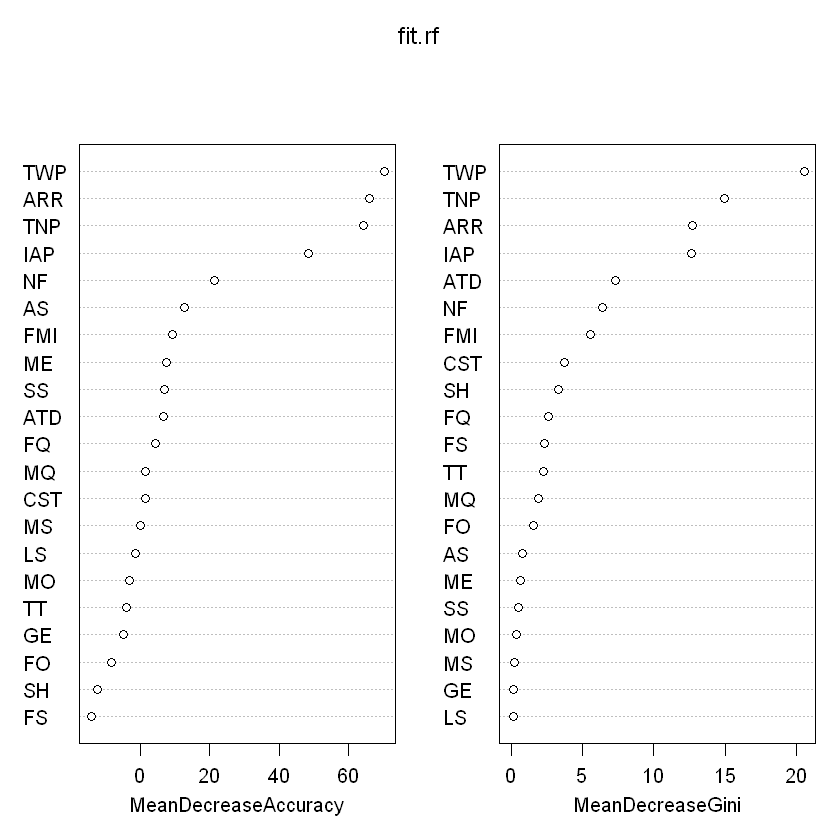

In [ ]:
fit.rf<-randomForest(y_train ~ ., data=X_train,xtest=X_test,ytest=y_test,ntree=5000 ,mtry=p, importance=TRUE)
fit.rf$importance
varImpPlot(fit.rf)

# Les variables les plus importantes sont : ('TWP', 'TNP', 'ARR')

### Forêts aléatoires

><u>Tâche 10</u> : Effectuer une prédiction en utilisant les forêts aléatoires. Pour différents nombres de variables explicatives échantillonnées $m=\sqrt{p}$, $m=p/2$ où $p$ est le nombre total de variables explicatives ($p=21$), tracer le taux d'erreur sur l'ensemble de test en fonction du nombre d'arbres utilisés. Tracer sur le même graphe le taux d'erreur 'out-of-bag'
 

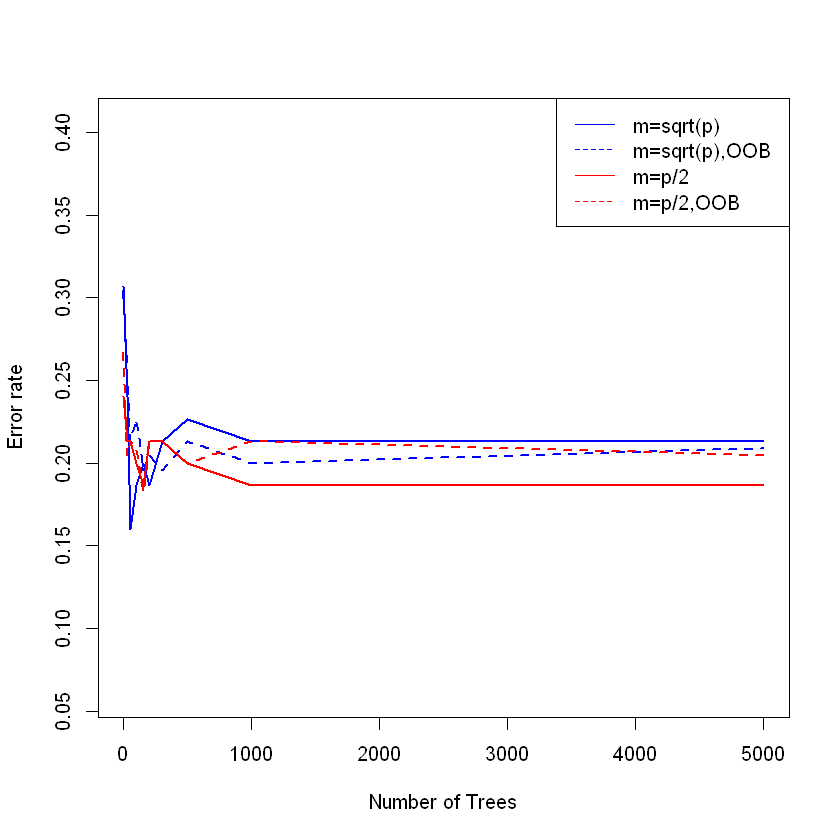

In [ ]:
error_rate<-c()
error_rate_oo<-c()
p=21
Ntrees=c(1,30,50,100,150,200,300,500,1000,5000)
for( m in c(sqrt(p),p/2)){
    for(i in Ntrees){
        fit.rf <- randomForest(y_train ~ ., data=X_train,xtest=X_test,ytest=y_test,ntree=i ,mtry=m,maxnodes=30, importance=TRUE)
        cm<-fit.rf$confusion
        error_rate_oo<-c(error_rate_oo,1-sum(diag(cm))/sum(cm[,-3]))
        confMat<-fit.rf$test$confusion
        error_rate<-c(error_rate,1-sum(diag(confMat))/sum(confMat[,-3]))
    }
}
l=length(Ntrees)
plot(Ntrees,error_rate[(1:l)],type='l',col='blue',lwd=2,ylim=c(min(error_rate)-0.1,max(error_rate)+0.1),ylab="Error rate",xlab="Number of Trees")
points(Ntrees,error_rate_oo[(1:l)],type='l',col='blue',lty=2,lwd=2)
points(Ntrees,error_rate[((1+l):(2*l))],type='l',col='red',lwd=2,ylab="Error rate",xlab="Number of Trees")
points(Ntrees,error_rate_oo[((1+l):(2*l))],type='l',col='red',lty=2,lwd=2)
legend("topright", legend=c("m=sqrt(p)","m=sqrt(p),OOB","m=p/2","m=p/2,OOB"),lty = c(1,2,1,2),col=c("blue","blue","red","red"))

><u>Tâche 11</u> : Déterminer quelles sont les variables les plus importantes en utilisant l'attribut `importance` et/ou la fonction `varImpPlot` pour la méthode de forêt aléatoire la plus performante.

 [1] 0.3066667 0.2400000 0.1600000 0.1866667 0.2000000 0.1866667 0.2133333
 [8] 0.2266667 0.2133333 0.2133333 0.2400000 0.2133333 0.2133333 0.2000000
[15] 0.1866667 0.2133333 0.2133333 0.2000000 0.1866667 0.1866667


,Fail,Pass,MeanDecreaseAccuracy,MeanDecreaseGini
GE,-6.742129e-04,-3.595253e-04,-4.352305e-04,0.2895070
CST,1.082912e-03,1.789820e-03,1.520358e-03,3.8706677
TNP,5.475861e-02,2.334598e-02,3.387911e-02,14.6875192
TWP,6.665506e-02,3.197991e-02,4.374276e-02,18.5578982
IAP,5.870435e-02,9.617586e-03,2.614215e-02,13.0967684
ARR,6.711619e-02,3.153048e-02,4.347644e-02,11.7949752
MS,0.000000e+00,0.000000e+00,0.000000e+00,0.2022854
LS,-1.253459e-04,1.716578e-04,5.410557e-05,0.2237581
AS,4.695759e-03,1.427409e-03,2.550998e-03,1.1188718
FMI,2.659583e-03,4.075070e-03,3.489353e-03,5.6986174


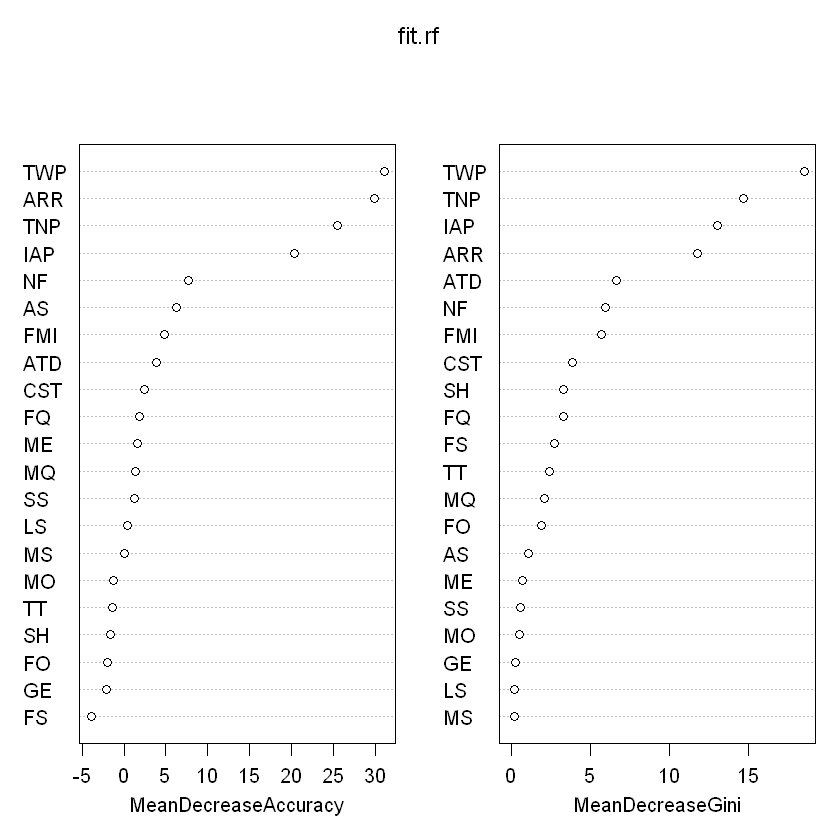

In [ ]:
#insert code
print(error_rate)
fit.rf <- randomForest(y_train ~ ., data=X_train,xtest=X_test,ytest=y_test,ntree=1000 ,mtry=p/2,maxnodes=30, importance=TRUE)
fit.rf$importance
varImpPlot(fit.rf)

# Les variables les plus importantes sont : ('TWP', 'ARR', 'TNP', 'IAP')

### Boosting

><u>Tâche 12</u> : En utilisant la méthode de boosting, via la fonction `gbm` du package du même nom, contruire une séquence de $5000$ arbres. Calculer le taux d'erreur sur l'ensemble de test. Tracer le taux d'erreur en fonction du nombre d'arbres.

In [259]:
Train$ESP<-(Train$ESP=='Pass')

GE,CST,TNP,TWP,IAP,ARR,MS,LS,AS,FMI,...,MQ,FO,MO,NF,SH,SS,ME,TT,ATD,ESP
M,G,0.44,0.59,0.50,Y,Unmarried,V,Free,3145,...,Il,Farmer,Housewife,7,1.0,Govt,Asm,0.50,0.77,Fail
M,SC,0.58,0.41,0.52,N,Unmarried,V,Paid,3483,...,10,Business,Housewife,1,1.5,Govt,Asm,0.75,0.77,Pass
M,MOBC,0.56,0.56,0.57,Y,Unmarried,V,Paid,11368,...,Um,Service,Housewife,20,5.0,Govt,Asm,1.75,0.11,Pass
F,G,0.50,0.50,0.46,Y,Unmarried,V,Paid,6337,...,Il,Business,Housewife,2,2.5,Govt,Eng,0.00,0.60,Fail
M,OBC,0.36,0.39,0.48,Y,Unmarried,V,Free,2987,...,Il,Farmer,Housewife,16,1.0,Govt,Eng,0.75,0.77,Fail
F,OBC,0.55,0.56,0.58,Y,Unmarried,V,Free,8842,...,10,Farmer,Housewife,2,3.5,Govt,Asm,0.75,0.66,Fail
M,OBC,0.96,0.60,0.60,Y,Unmarried,V,Paid,10732,...,Um,Business,Housewife,16,1.0,Govt,Eng,1.00,0.61,Pass
F,OBC,0.54,0.45,0.54,Y,Unmarried,T,Paid,19472,...,Um,Service,Housewife,10,0.5,Govt,Eng,0.25,0.28,Fail
M,OBC,0.58,0.57,0.59,Y,Unmarried,V,Free,9020,...,Um,Farmer,Housewife,13,2.5,Govt,Asm,0.50,0.81,Pass
F,ST,0.58,0.58,0.46,Y,Unmarried,T,Paid,19928,...,Il,Service,Housewife,1,1.0,Govt,Eng,0.25,0.21,Pass


Distribution not specified, assuming bernoulli ...
Distribution not specified, assuming bernoulli ...


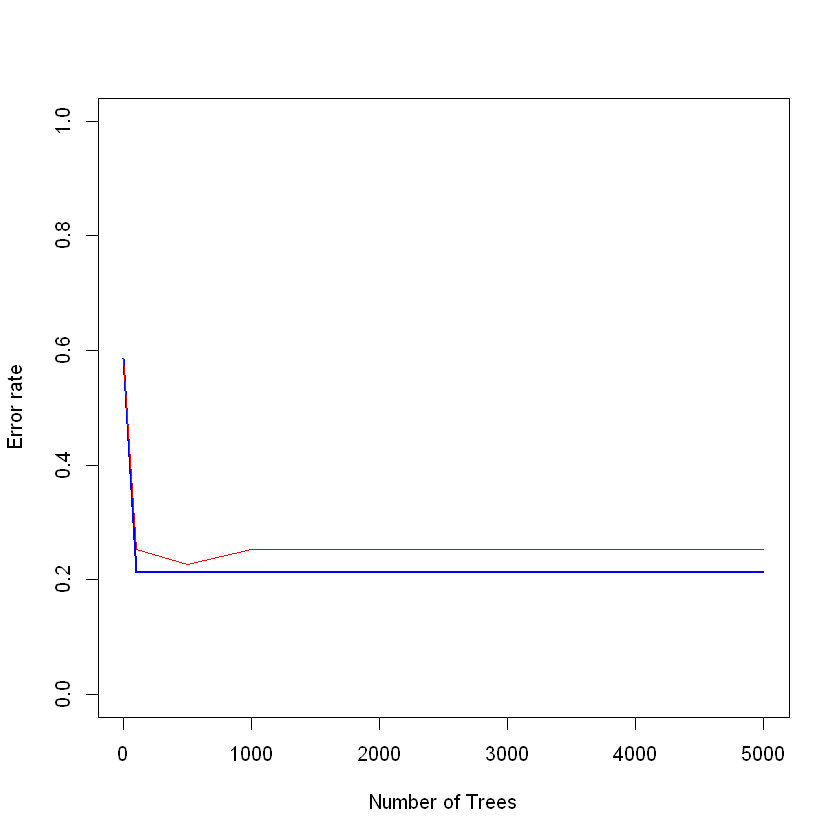

In [ ]:
error_rate3<-c()
error_rate1<-c()
fit3.boost<-gbm(ESP~.,data=Train,n.trees=5000,interaction.depth = 3)
fit1.boost<-gbm(ESP~.,data=Train,n.trees=5000,interaction.depth = 1)
for (i in c(1,100,500,1000,5000)){
    pred3.boost <- predict(fit3.boost, newdata = X_test, n.trees =i, type="response")
    labels = (pred3.boost>=0.5)
    cm = table(y_test, labels)
    error_rate3<-c(error_rate3,1-sum(diag(cm))/sum(cm))
}
for (i in c(1,100,500,1000,5000)){
    pred1.boost <- predict(fit1.boost, newdata = X_test, n.trees =i, type="response")
    labels = (pred1.boost>=0.5)
    cm = table(y_test, labels)
    error_rate1<-c(error_rate1,1-sum(diag(cm))/sum(cm))
}
plot(c(1,100,500,1000,5000),error_rate3,type='l',col='blue',lwd=2,ylim=c(0,1),ylab="Error rate",xlab="Number of Trees")
lines(c(1,100,500,1000,5000),error_rate1,type='l',col='red')

><u>Tâche 13</u> : Utiliser la fonction `summary` pour identifier les variables d'importance.

,var,rel.inf
TWP,TWP,15.126605677
TNP,TNP,14.006139111
IAP,IAP,12.328145938
ARR,ARR,11.856071053
ATD,ATD,7.966751052
FMI,FMI,6.669903157
NF,NF,5.684601116
FQ,FQ,5.318228347
CST,CST,5.102181729
FO,FO,3.696716990


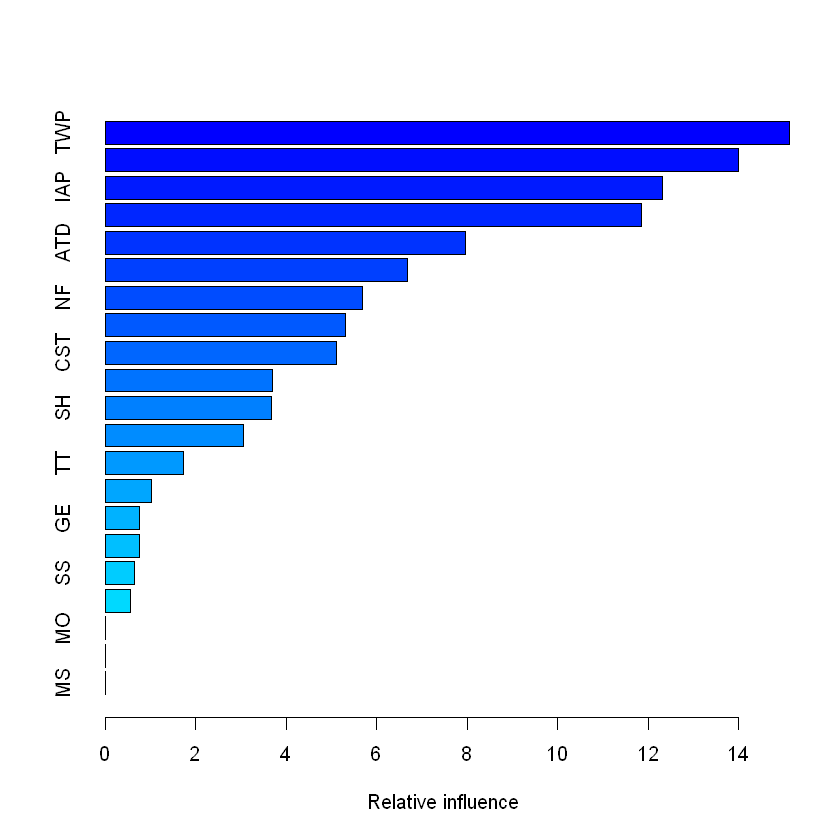

In [ ]:
summary(fit3.boost, n.trees = 5000)

## Comparaison

Dans cette dernière partie, on applique une autre méthode de classification à notre jeu de données à titre de comparaison avec les méthodes par arbres en général. On se tourne vers une méthode qui est également adaptée, c'est-à-dire qui est capable de traiter des variables quantitatives et qualitatives non-ordonnées. On choisit la régression logistique multinomiale `multinom` fournie par la librairie `nnet` de R. 

><u>Tâche 14</u> : Effectuer une régression logistique multinomiale sur le jeu de données et déterminer son taux d'erreur sur l'ensemble de test.

In [ ]:
fit.glm<-multinom(ESP~.,Train)
pred<-predict(fit.glm,X_test,type='class')
cm = table(y_test, pred)
error_rate<-1-sum(diag(cm))/sum(cm)
print(error_rate)
summary(fit.glm)

# weights:  40 (39 variable)
initial  value 155.958116 
iter  10 value 84.299601
iter  20 value 69.217007
iter  30 value 67.585373
iter  40 value 67.548972
iter  50 value 67.535012
iter  60 value 67.534324
final  value 67.534262 
converged
[1] 0.2133333


Call:
multinom(formula = ESP ~ ., data = Train)

Coefficients:
                   Values    Std. Err.
(Intercept) -1.750987e+02 1.883954e-02
GEM          2.287231e-01 1.054828e-02
CSTMOBC      9.272503e-01 4.597993e-03
CSTOBC       1.057380e+00 6.395380e-03
CSTSC        1.092455e+00 1.626194e-03
CSTST        1.512531e+00 2.257949e-03
TNP          8.576651e+00 8.283566e-03
TWP          7.744732e+00 9.713205e-03
IAP          8.405076e+00 1.170233e-02
ARRY        -2.695302e+00 1.585433e-02
MSUnmarried  1.617570e+02 1.883954e-02
LSV          1.734313e-01 1.960400e-02
ASPaid       4.916285e-01 1.418752e-03
FMI         -1.899105e-05 3.009895e-05
FS           9.120762e-02 6.494524e-02
FQ12         1.958665e+00 3.718318e-03
FQDegree     2.396967e+00 5.113485e-04
FQIl         6.560962e-01 2.904885e-03
FQPg        -8.154531e-01 5.987380e-05
FQUm         1.356272e-01 1.112195e-02
MQ12        -1.379345e+00 1.935796e-03
MQDegree     4.144674e+01 0.000000e+00
MQIl        -4.572316e-01 3.578931e-03
M

## Interprétation

<b>Discuter la performance des méthodes testées.</b>
<li>Au niveau de l'arbre de décision, l'utilisation de Gini donne un meilleur résultat que de l'enthropie dans ce jeu de données, afin d'identifier le critère d'impurité.
<li>A la base, l'arbre de décision nécessite beaucoup de "Pruning" et de fine-tuning afin d'avoir un bon résultat. Pour ce fait, l'utilisation du forêt aléatoire est important comme méthode de bagging.
<li>Enfin, une comparaison entre Bagging, Boosting, Forêt Aléatoire et Régression Logistique Multinomiale. Les variables importantes diffèrent selon le modèle utilisé, pour le boosting et forêt aléatoire, les variables sont plus ou moins les mêmes. Au niveau du boosting, c'est un peu plus différent.<br><br>
<b>Identifier les facteurs de réussite d'un étudiant. En particulier, discuter l'impact des facteurs socio-économiques tels que le sexe, la classe sociale, le revenu et des facteurs éducatifs (école privée ou publique, langue d'enseignement).</b><br>
<br><li><b>Arbre 3: </b>Dans les arbres bruts ci-dessous, on note que le facteur éducatif notamment lié à l'école (Privé ou Publique) affecte la réussite; 80% réusissent.
<li><b>Arbre 1: </b>Par rapport au sexe, 55.5% des Females réusissent, alors que 55% des Males échouent, cela est assez équilibré. Au niveau de la langue, , et le type d'école (gratuit/payant), 
<li><b>Arbre 2: </b>Au niveau du revenu, sur la base d'un revenu qui s'approche de la moyenne (Seuil du revenu sur l'arbre: 9594 - Moyenne du revenu du jeu de test entier: 10683), au delà de ce seuil, 80% réusissent. Quant à un revenu entre 3130 et 3376, seulement 1/9 réusissent, par contre 71.5% réusissent avec un revenu entre 2645 et 3130.

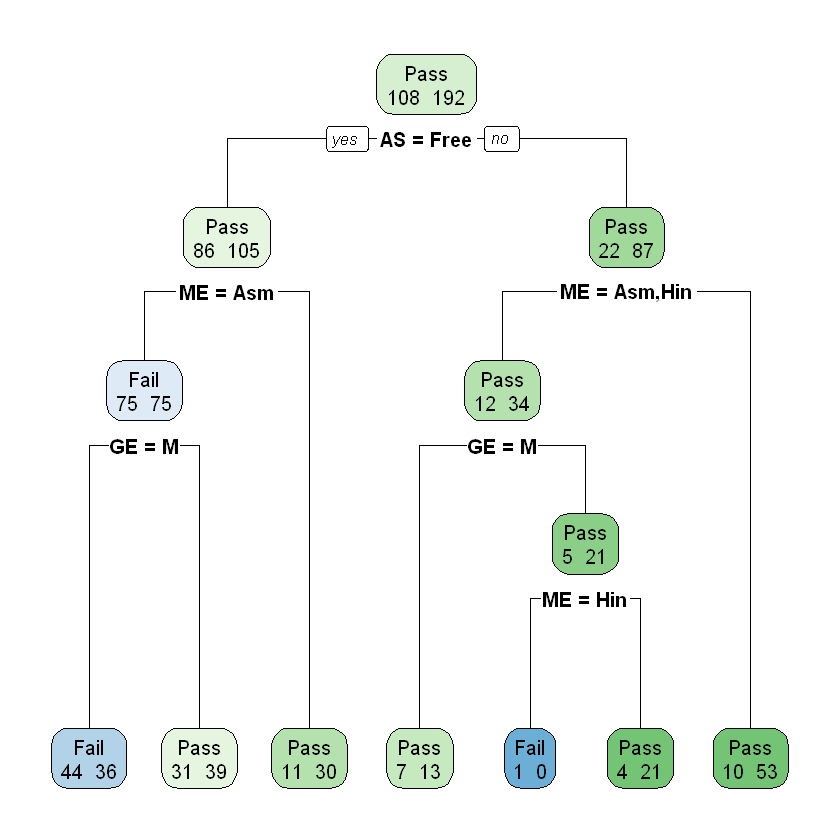


Classification tree:
rpart(formula = y_train1 ~ FMI + GE + ME + AS, data = X_train1)

Variables actually used in tree construction:
[1] AS  FMI ME 

Root node error: 108/300 = 0.36

n= 300 

        CP nsplit rel error  xerror     xstd
1 0.055556      0   1.00000 1.00000 0.076980
2 0.013889      3   0.83333 0.89815 0.075015
3 0.010000      9   0.75000 0.95370 0.076150


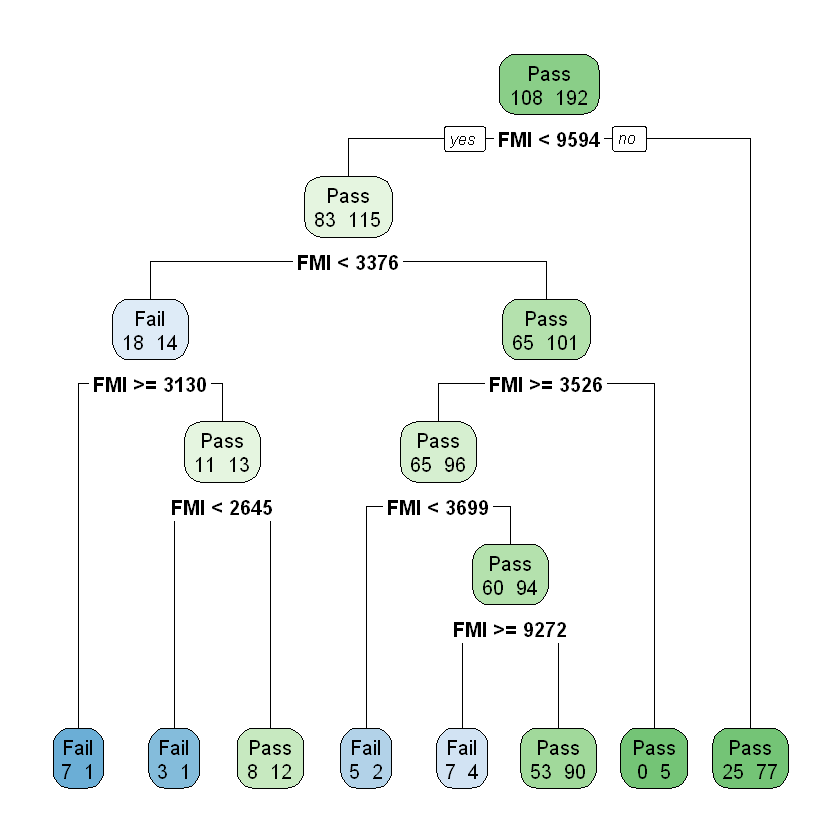

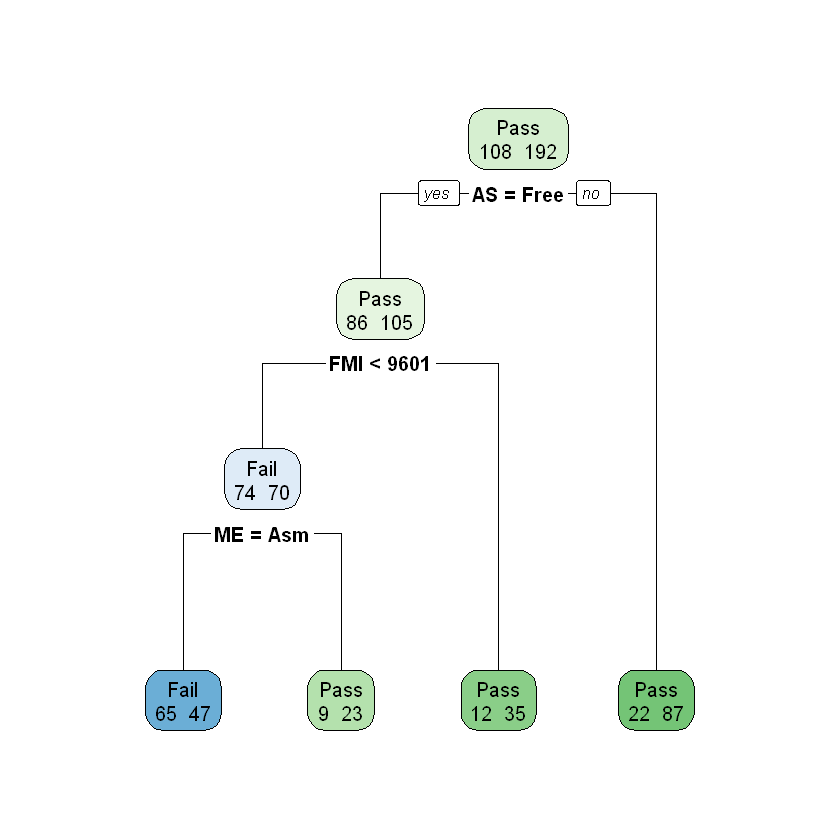

In [477]:
# Main Data
data <- rbind(Train, Test)

X_train1 <- data[, -22]
y_train1 <- data[, 22]

# Tree 1 (All except income)
# tree1 <- rpart(y_train1~ GE + ME + AS,data=X_train1, control = rpart.control(cp=0,minsplit=5))
tree1 <- rpart(y_train1~ GE + ME + AS,data=X_train1, control = rpart.control(cp=0,minsplit=4))
rpart.plot(tree1,extra=1)

# Tree 2 (Only income)
tree2 <- rpart(y_train1~ FMI,data=X_train1, control = rpart.control(cp=0.0184,minsplit=4))
# prune(tree2, cp=0.01)
rpart.plot(tree2,extra=1)

# Tree 3 (All)
tree3 <- rpart(y_train1~ FMI + GE + ME + AS,data=X_train1)
printcp(tree3)
tree3 <- prune(tree3, cp=0.013889)
rpart.plot(tree3,extra=1)


In [400]:
summary(X_train1$FMI)
sum(data$ESP == 'Fail')

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   2552    4664    7792   10683   12199   80292 

[1] 108

## Références 

<a name="mcdaniel"/> McDaniel, T. (2018) _Using Random Forests to Describe Equity in Higher Education: A Critical Quantitative Analysis of Utah’s Postsecondary Pipelines, Butler Journal of Undergraduate Research: Vol. 4 , Article 10_.

<a name="hussain"/> Hussain, S., Dahan, N. A., Ba-Alwib, F. M., & Ribata, N . (2018) _Educational data mining and analysis of students’ academic performance using WEKA. Indonesian Journal of Electrical Engineering and Computer Science, 9(2), 447-459._.